In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline

import matplotlib.pyplot as plt

## Load In the Data

In [7]:
skin_df = pd.read_csv('hmnist_64_64_RGB.csv')

In [8]:
skin_df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel12279,pixel12280,pixel12281,pixel12282,pixel12283,pixel12284,pixel12285,pixel12286,pixel12287,label
0,185,108,136,151,71,108,176,89,128,191,...,180,97,139,190,113,151,229,179,194,2
1,116,26,53,139,30,51,152,38,59,138,...,137,32,53,140,34,55,148,32,56,2
2,176,82,123,176,85,125,195,106,144,210,...,196,93,139,147,57,102,177,93,130,2
3,152,52,89,139,52,90,148,57,97,158,...,156,45,65,118,35,70,85,27,62,2
4,214,144,179,182,121,162,178,120,152,180,...,189,117,156,200,136,169,197,125,155,2


In [64]:
X = skin_df.drop("label", axis=1).to_numpy()
label = skin_df["label"].values


In [29]:
X.shape, label.shape

((5000, 12288), (5000,))

## Scaling and Split Data into Train, Validation and Test set

In [12]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std

In [13]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

In [14]:
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((4500, 12288), (500, 12288), (4500,), (500,))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)

In [16]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3600, 12288), (900, 12288), (3600,), (900,))

## Reshape the Data to Input in CNN

In [17]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))

In [18]:
X_train.shape, X_val.shape, X_test.shape

((3600, 64, 64, 3), (900, 64, 64, 3), (500, 64, 64, 3))

In [19]:
y_train.shape

(3600,)

In [20]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [21]:
y_train.shape, y_val.shape, y_test.shape

((3600, 9), (900, 9), (500, 9))

## CNN Model

In [65]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(9, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


C:\Users\RaziButt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [66]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 64)        184

## Define Data Generator for Data Augmentation and Learning Rate Adaptive Reduction to Prevent Overfitting

In [67]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [68]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [69]:
batch_size = 64
epochs = 30
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/30
56/56 [==============================] - 20s 287ms/step - loss: 1.1106 - accuracy: 0.5130 - val_loss: 0.7924 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 2/30
56/56 [==============================] - 16s 282ms/step - loss: 0.8036 - accuracy: 0.6759 - val_loss: 0.6352 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 3/30
56/56 [==============================] - 16s 285ms/step - loss: 0.6604 - accuracy: 0.7525 - val_loss: 0.6466 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 4/30
56/56 [==============================] - 16s 293ms/step - loss: 0.6473 - accuracy: 0.7534 - val_loss: 0.5195 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 5/30
56/56 [==============================] - 16s 286ms/step - loss: 0.5657 - accuracy: 0.7899 - val_loss: 0.4819 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 6/30
56/56 [==============================] - 16s 288ms/step - loss: 0.5419 - accuracy: 0.7995 - val_loss: 0.5043 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 7/30
56/56 [==============================] - 18s 312ms/st

56/56 [==============================] - 16s 280ms/step - loss: 0.3297 - accuracy: 0.8838 - val_loss: 0.3760 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 22/30
56/56 [==============================] - 16s 280ms/step - loss: 0.3715 - accuracy: 0.8614 - val_loss: 0.3308 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 23/30
56/56 [==============================] - 16s 278ms/step - loss: 0.3487 - accuracy: 0.8761 - val_loss: 0.3066 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 24/30
56/56 [==============================] - 17s 299ms/step - loss: 0.3536 - accuracy: 0.8705 - val_loss: 0.3223 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 25/30
56/56 [==============================] - 16s 278ms/step - loss: 0.3507 - accuracy: 0.8750 - val_loss: 0.3927 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 26/30
56/56 [==============================] - 16s 276ms/step - loss: 0.3092 - accuracy: 0.8891 - val_loss: 0.3388 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 27/30
56/56 [==============================] - 16s 284ms/step - 

In [70]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("model.h5")

29/29 [==============================] - 1s 37ms/step - loss: 0.3828 - accuracy: 0.8733
Validation: accuracy = 0.873333  ;  loss_v = 0.382754
Test: accuracy = 0.886000  ;  loss = 0.307741


Text(0.5, 1.0, 'Training and validation loss')

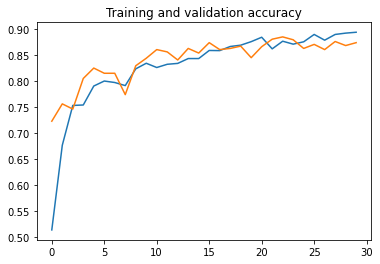

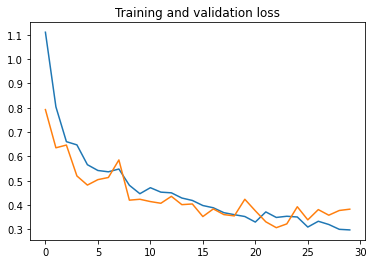

In [72]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')